# SOM - CESM Member 001
## V6 - Monthly/Yearly split

#### Template from 'Basic uses of SOMPY library', modified for our use
* http://www.vahidmoosavi.com
* https://github.com/sevamoo/sompy

#### Notebook Features
* Import packages required for SOM module SOMPY, and SOMPY itself (note this must be cloned from repo into local dir
* Load Data
* Clean & organize data into format/interval of interest
* Quick visualizations for context
* 

In [2]:
import matplotlib
#import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd
import numpy as np
from time import time
import sompy

from sklearn.preprocessing import StandardScaler

import os
import xarray as xr

import datetime

import math
import glob

from sklearn.externals import joblib
import random

from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

import random

backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
os.getcwd()

'/Users/cg/co2/ocean-co2-absorption/notebooks/SOM'

In [4]:
#Windows
#DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'

#Mac
DATA_DIR = '/Users/cg/co2/'

#Define key names and import .nc data
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [24]:
#create dataframe for data prep

df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [25]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['pCO2']['pCO2']], axis=1)

In [26]:
SOM_input.shape

(17290470, 7)

In [27]:
SOM_input.sample(10)

,time,ylat,xlon,SSS,MLD,SST,pCO2
13585421,2009-07-16 12:00:00,44.5,181.5,32.961853,20.380001,12.674815,409.820156
13156327,2008-09-16 00:00:00,-30.5,187.5,35.089207,57.484966,17.167505,333.794945
6119588,1994-06-16 00:00:00,-75.5,320.5,34.371231,91.294540,-1.774947,337.117638
1300234,1984-08-16 12:00:00,18.5,161.5,34.553516,44.742931,27.818468,337.078586
6718994,1995-08-16 12:00:00,8.5,254.5,33.207008,35.157974,28.093830,399.340406
15824004,2014-02-15 00:00:00,-36.5,114.5,35.297787,52.576347,18.515985,361.056480
130812,1982-04-16 00:00:00,-49.5,127.5,33.706268,82.149513,7.124059,330.538241
8941367,2000-02-15 12:00:00,27.5,323.5,37.104652,125.729286,21.190739,352.696147
16934038,2016-05-16 12:00:00,-33.5,348.5,34.945602,60.332077,19.356855,381.789924
711468,1983-06-16 00:00:00,-32.5,79.5,34.639500,71.769875,18.420425,324.468920


In [28]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

#log convert MLD
SOM_input['logMLD'] = SOM_input['MLD'].apply(np.log)

### Clean/label data so it can more easily be split up over different timeframes

In [29]:
#convert time info into date-time format
SOM_input.set_index(pd.DatetimeIndex(SOM_input['time']))

#create month column
SOM_input['month'] = pd.DatetimeIndex(SOM_input['time']).month

#create year column
SOM_input['year'] = pd.DatetimeIndex(SOM_input['time']).year

SOM_input['day'] = pd.DatetimeIndex(SOM_input['time']).day


In [30]:
SOM_input.loc[(SOM_input['year'] == 1984) & (SOM_input['month'] == 03) & (SOM_input['ylat'] == 25.5) & (SOM_input['xlon'] == 187.5)]

,time,ylat,xlon,SSS,MLD,SST,pCO2,logMLD,month,year,day
1096462,1984-03-16 12:00:00,25.5,187.5,35.064877,78.859482,19.716835,294.272768,4.367668,3,1984,16


In [50]:
Sample = SOM_input.drop(columns=['time','day']).sample(frac=0.1)

In [51]:
Sample.head()

,ylat,xlon,SSS,MLD,SST,pCO2,logMLD,month,year
5092967,-73.5,199.5,33.802910,68.647316,-1.803038,304.061664,4.228982,5,1992
13424171,68.5,350.5,34.467411,47.563656,-0.506848,336.493103,3.862069,3,2009
2472360,-48.5,342.5,33.764130,40.557926,8.260082,294.606918,3.702731,1,1987
9345747,2.5,156.5,34.661919,143.128479,27.437641,370.803150,4.963743,12,2000
14350298,-19.5,105.5,34.450195,37.320671,24.581621,375.083316,3.619547,2,2011


In [52]:
Sample.shape

(1727574, 9)

In [53]:
Sample_matrix = Sample.values

# Scale Data

#### choice of normalization or transform? 
* Note.. lessons learned from prior optimization:
* - log transform of MLD improved perf
* - StandardScaler demonstrates same perf as 'var' norm option within SOMPY engine
* - variance-based normalization is best choice based on analysis of other scaling options

In [52]:
#ss = StandardScaler().fit_transform(Years[['SSS','SST','MLD','pCO2']])

In [54]:
#tuning parameters
#research suggests M = 5*sqrt(N) is a good choice for number of neurons
M = 5*np.sqrt(Sample_matrix.shape[0])

#calculate grid dimension (for square grid), as basis for optimization of map size
m=int(np.sqrt(M))

M, m

(6571.86046717366, 81)

### Notes on SOM tuning
* testing suggests pca is faster than random init but limits # of epochs/trainlen internal to SOM engine
* batch faster than sequential.. only batch implemented currently

In [58]:
map_size = [m,m]
names = ['SSS','SST','logMLD','pCO2']
 
sm = sompy.SOMFactory().build(Sample_matrix, mapsize = map_size, mapshape = 'planar',
                            initialization='pca',
                            normalization = 'var', 
                            component_names=names, lattice='rect') 
sm.train(n_job=1, 
         verbose='info', 
         train_rough_len= 10,
         train_finetune_len= 20,
         #train_rough_radiusin=14,
         #train_rough_radiusfin=3.5,
         #train_finetune_radiusin=3.5,
         #train_finetune_radiusfin=1
        ) 
    
joblib.dump(sm, "test81.81.joblib")

 Training...
 pca_linear_initialization took: 3.730000 seconds
 Rough training...
 radius_ini: 11.000000 , radius_final: 2.750000, trainlen: 10

 epoch: 1 ---> elapsed time:  217.692000, quantization error: 2.219177

 epoch: 2 ---> elapsed time:  223.116000, quantization error: 1.991063

 epoch: 3 ---> elapsed time:  210.932000, quantization error: 1.765814

 epoch: 4 ---> elapsed time:  212.765000, quantization error: 1.613686

 epoch: 5 ---> elapsed time:  208.518000, quantization error: 1.513721

 epoch: 6 ---> elapsed time:  201.067000, quantization error: 1.427103

 epoch: 7 ---> elapsed time:  206.328000, quantization error: 1.344559

 epoch: 8 ---> elapsed time:  208.304000, quantization error: 1.263330

 epoch: 9 ---> elapsed time:  198.352000, quantization error: 1.177880

 epoch: 10 ---> elapsed time:  205.126000, quantization error: 1.083123

 Finetune training...
 radius_ini: 2.750000 , radius_final: 1.000000, trainlen: 20

 epoch: 1 ---> elapsed time:  203.446000, quantiza

['test81.81.joblib']

### From Original SOMtoolbox documentation
* http://www.cis.hut.fi/somtoolbox/package/docs2/som_quality.html

*     qe : Average distance between each data vector and its BMU.
       Measures map resolution.
*     te : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

In [59]:
# Observe results
# note this works to compare multiple SOM training runs...
# but also can just produce results from single training session. 
# use * wildcard, e.g., './Model_xxx_*', to add multiple models to pool for results eval
results = joblib.load("./test81.81.joblib")
topographic_error = results.calculate_topographic_error()
quantization_error = results.calculate_quantization_error()

In [60]:
print("TE: ",topographic_error,"QE: ",quantization_error)

('TE: ', 0.17349242347939944, 'QE: ', 0.1631958416045809)


In [75]:
results.calculate_map_size('rect')

[63, 104]

In [ ]:
sm.calculate_map_size('rect')

In [61]:
map_labels_k5 = results.cluster(n_clusters=5)
data_labels_k5 = np.array([map_labels_k5[int(k)] for k in results._bmu[0]])
map_labels_k10 = results.cluster(n_clusters=10)
data_labels_k10 = np.array([map_labels_k10[int(k)] for k in results._bmu[0]])
map_labels_k15 = results.cluster(n_clusters=15)
data_labels_k15 = np.array([map_labels_k15[int(k)] for k in results._bmu[0]])

Sample['k=5'] = data_labels_k5
Sample['k=10'] = data_labels_k10
Sample['k=15'] = data_labels_k15

Sample.to_csv('./10%_Sample_w_clusters.csv',
              sep=',',
              na_rep='NaN',
              columns=[u'ylat', u'xlon', u'SSS', u'MLD', u'SST', u'pCO2', u'logMLD', u'month', u'year', u'k=5', u'k=10', u'k=15'],
              header=True,
              index=True,
              mode='w')

In [65]:
Sample.shape

(1727574, 12)

In [ ]:
ylat	xlon	SSS	MLD	SST	pCO2	logMLD	month	year

IndexError: list index out of range

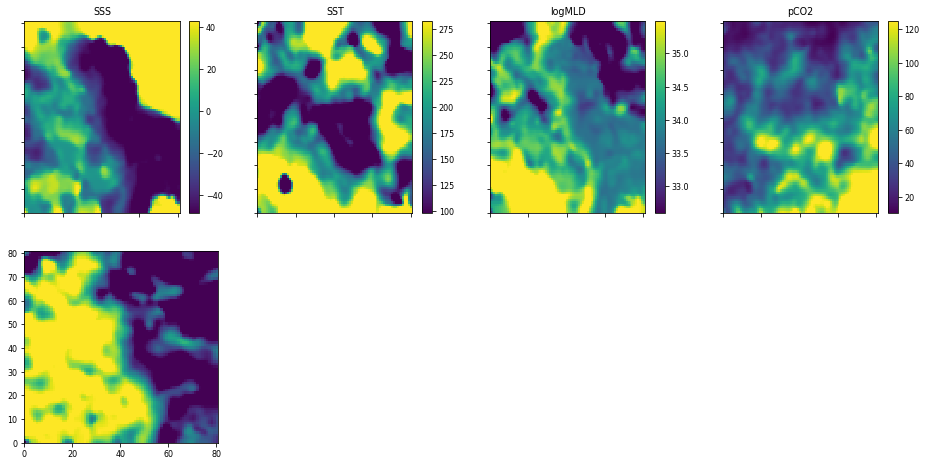

In [76]:
from sompy.visualization.mapview import View2D
v2D = View2D(63,104, 'Optimized Component Heatmaps',text_size=8)  
v2D.show(sm, col_sz=4, denormalize=True)

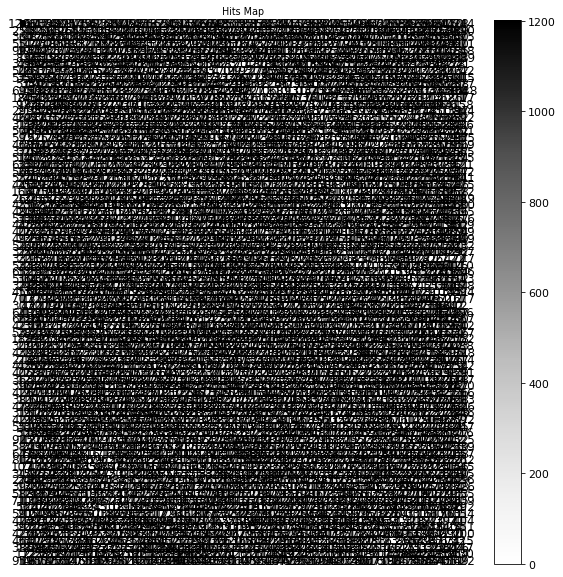

In [74]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=11)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [ ]:
u = sompy.umatrix.UMatrixView(63,104, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(sm, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(sm, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)
